In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

2023-06-05 22:49:33.955207: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Dataset preparation

### Set parameters

In [2]:
batch_size = 8
img_height = 184
img_width = 216
img_size = (img_height, img_width)
img_shape = img_size + (1,)
ds_path = "/drive0-storage/Gracia/dataset"

### Load dataset

In [3]:
from tensorflow.keras.utils import image_dataset_from_directory

with tf.device("CPU"):
    train_ds = image_dataset_from_directory(ds_path,
                                            validation_split = 0.2,
                                            subset = "training",
                                            seed = 123,
                                            image_size = img_size,
                                            batch_size = batch_size)

    val_ds = image_dataset_from_directory(ds_path,
                                          validation_split = 0.2,
                                          subset = "validation",
                                          seed = 123,
                                          image_size = img_size,
                                          batch_size = batch_size)

2023-06-05 22:49:35.986946: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-05 22:49:36.750326: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1637] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7910 MB memory:  -> device: 0, name: A100-SXM4-40GB MIG 2g.10gb, pci bus id: 0000:90:00.0, compute capability: 8.0


Found 21413 files belonging to 3 classes.
Using 17131 files for training.
Found 21413 files belonging to 3 classes.
Using 4282 files for validation.


In [4]:
class_names = train_ds.class_names
num_classes = len(class_names)

print(class_names)

['bd', 'hc', 'sz']


### Train, validation, test set

In [5]:
def preprocess(image, label):
    image = tf.image.rgb_to_grayscale(image)
    return image, label

with tf.device("CPU"):
    val_batches = tf.data.experimental.cardinality(val_ds)
    test_dataset = val_ds.take(val_batches // 2)
    validation_dataset = val_ds.skip(val_batches // 2)
    
    # Buffered prefetching
    AUTOTUNE = tf.data.AUTOTUNE
    BUFFER_SIZE = 1000

    train_dataset = (train_ds
                    .shuffle(buffer_size = BUFFER_SIZE)
                    .map(preprocess, num_parallel_calls=AUTOTUNE)
                    .prefetch(AUTOTUNE)
                    )

    validation_dataset = (validation_dataset
                        .shuffle(buffer_size = BUFFER_SIZE)
                        .map(preprocess, num_parallel_calls=AUTOTUNE)
                        .prefetch(AUTOTUNE)
                         )
                
    test_dataset = (test_dataset
                    .shuffle(buffer_size = BUFFER_SIZE)
                    .map(preprocess, num_parallel_calls=AUTOTUNE)
                    .prefetch(AUTOTUNE)
                   )

In [6]:
print(f"train batches: {len(train_dataset)}")
print(f"validation batches: {len(validation_dataset)}")
print(f"test batches: {len(test_dataset)}")

train batches: 2142
validation batches: 268
test batches: 268


### Transfer Learning InceptionV3

In [7]:
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input

with tf.device("CPU"):
    pre_trained_model = InceptionV3(input_shape = (None, None, 3),
                            include_top = False,
                            weights = 'imagenet')

    pre_trained_model.layers.pop(0)

# pre_trained_model.trainable = False

### Fine tuning layers

In [8]:
print("Number of layers: ", len(pre_trained_model.layers))

Number of layers:  311


In [9]:
with tf.device("CPU"):
    pre_trained_model.trainable = True

    # Fine-tune from this layer onwards
    START_TRAIN = 150

    # Freeze all the layers before 
    for layer in pre_trained_model.layers[:START_TRAIN]:
        layer.trainable = False

### Preprocess input and add classification layer

In [10]:
 with tf.device("CPU"):
    global_average = tf.keras.layers.GlobalAveragePooling2D()
    prediction_layer = tf.keras.layers.Dense(num_classes, activation='softmax')

    inputs = tf.keras.Input(shape = img_shape)
    rgb_tensor = tf.keras.layers.Concatenate()([inputs, inputs, inputs])
    x = preprocess_input(rgb_tensor)
    x = pre_trained_model(x, training=False)
    x = global_average(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    outputs = prediction_layer(x)
    model = tf.keras.Model(inputs,outputs)

### Compile model

In [11]:
# Compile model
with tf.device("CPU"):
    LR = 0.0001
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = LR),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
                  metrics=['accuracy'])

# Display model architecture
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 184, 216, 1  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_2 (Concatenate)    (None, 184, 216, 3)  0           ['input_2[0][0]',                
                                                                  'input_2[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 184, 216, 3)  0           ['concatenate_2[0][0]']      

## Model training

In [12]:
# Callback function
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.90):
            print("\nReached 90% accuracy so cancelling training!")
            self.model.stop_training = True
            
callbacks = myCallback()

- InceptionV3

In [13]:
EPOCH = 15

history_inception = model.fit(
            train_dataset,
            validation_data = validation_dataset,
            epochs = EPOCH,
            callbacks=[callbacks])

Epoch 1/15


2023-06-05 22:49:46.537094: I tensorflow/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-06-05 22:49:47.593571: I tensorflow/stream_executor/cuda/cuda_blas.cc:1633] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


2142/2142 [==============================] - 63s 26ms/step - loss: 0.9855 - accuracy: 0.5593 - val_loss: 0.9751 - val_accuracy: 0.5496
Epoch 2/15
2142/2142 [==============================] - 56s 26ms/step - loss: 0.8900 - accuracy: 0.5967 - val_loss: 0.8502 - val_accuracy: 0.6132
Epoch 3/15
2142/2142 [==============================] - 56s 25ms/step - loss: 0.7639 - accuracy: 0.6652 - val_loss: 0.7122 - val_accuracy: 0.6843
Epoch 4/15
2142/2142 [==============================] - 56s 25ms/step - loss: 0.5422 - accuracy: 0.7742 - val_loss: 0.5477 - val_accuracy: 0.7783
Epoch 5/15
2142/2142 [==============================] - 56s 25ms/step - loss: 0.3137 - accuracy: 0.8790 - val_loss: 0.3653 - val_accuracy: 0.8639
Epoch 6/15
2140/2142 [============================>.] - ETA: 0s - loss: 0.1755 - accuracy: 0.9344
Reached 90% accuracy so cancelling training!
2142/2142 [==============================] - 55s 25ms/step - loss: 0.1753 - accuracy: 0.9345 - val_loss: 0.2764 - val_accuracy: 0.8868


- InceptionV3

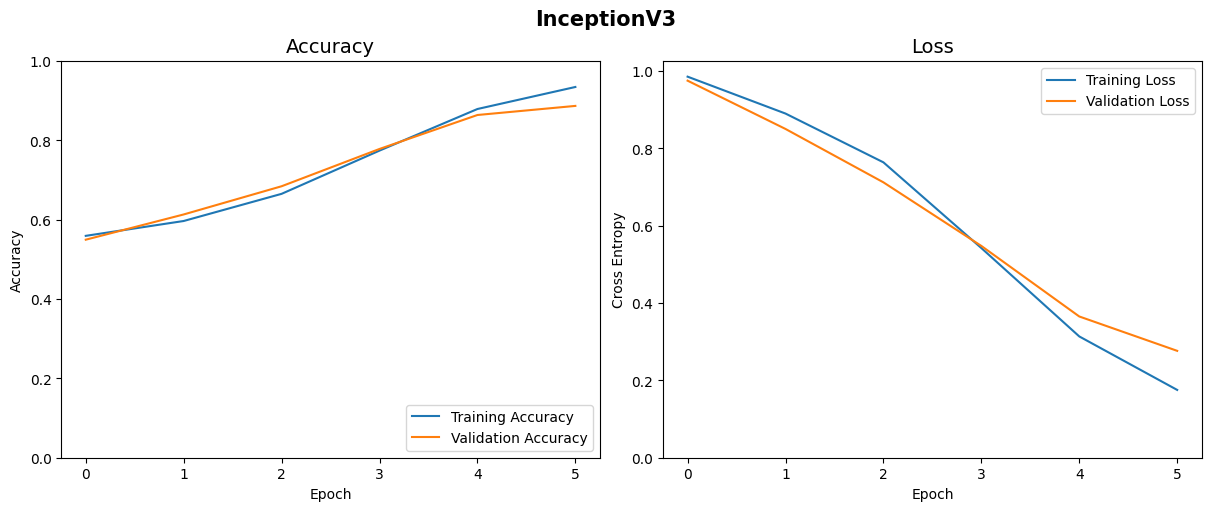

In [14]:
# training and validation accuracy
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5), constrained_layout=True)

acc = history_inception.history['accuracy']
val_acc = history_inception.history['val_accuracy']

ax[0].plot(acc, label='Training Accuracy')
ax[0].plot(val_acc, label='Validation Accuracy')
ax[0].legend(loc='lower right')
ax[0].set(xlabel='Epoch', ylabel='Accuracy', ylim=[min(plt.ylim()),1])
ax[0].set_title('Accuracy', size=14)

# training and validation loss
loss = history_inception.history['loss']
val_loss = history_inception.history['val_loss']

ax[1].plot(loss, label='Training Loss')
ax[1].plot(val_loss, label='Validation Loss')
ax[1].legend(loc='upper right')
ax[1].set(xlabel='Epoch', ylabel='Cross Entropy', ylim=[0,max(plt.ylim())])
ax[1].set_title('Loss', size=14)

fig.suptitle("InceptionV3", fontweight="bold", size=15)
plt.show()

In [15]:
model.save('transfer_learning_model.h5')